# Spell Checker

**Libraries**

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from random import randint
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

**Constants**

In [2]:
# Words which whose length/number of character are within
# the range [MIN_LEN, MAX_LEN] inclusive will be used.
MIN_LEN = 5
MAX_LEN = 10

# Small alphabets will be used only, remove number or special characters.
# Space is used for padding.
ALLOWED_CHARACTERS = " " + "".join([chr(i) for i in range(97, 123)])

# Encoding string labels/correct words to numbers
label_encoder = LabelEncoder()

In [3]:
def encode_string(word: str) -> []:
    """
        Parameter:
            word: string/word to be encoded into list of numbers.
        
        Returns:
            encoded_word_array: integer list of size MAX_LEN
    """
    if len(word) < MAX_LEN:
        word = word + (" " * (MAX_LEN - len(word)))
    elif len(word) > MAX_LEN:
        word = word[:MAX_LEN]
    
    encoded_word_array = [ALLOWED_CHARACTERS.index(char) for char in word]
    return encoded_word_array

def decode_string(encoded_word_array: []) -> str:
    """
        Parameter:
            encoded_word_array: array which was encoded by the function 'encoded_string'.
            
        Returns:
            word: decoded word/string from encoded_word_array.
    """
    word = "".join([ALLOWED_CHARACTERS[char] for char in encoded_word_array])
    return word.strip()

def plot_predictions(x, y, title=None):
    """
        Plots a bar chart of prediction percentage.
    """
    plt.figure(figsize=(5, 4))
    plt.bar(x, y.astype(np.float32), color="teal")
    plt.title(title)
    plt.xlabel("Words")
    plt.ylabel("Prediction %")
    plt.show()
    
def plot_history(history, labels: [], ylabel: str = None):
    plt.figure(figsize=(7, 5))
    for label in labels:
        plt.plot(history[label], label=label)
    plt.title("Training History")
    
    if ylabel:
        plt.ylabel(ylabel)
    plt.xlabel("No. epoch")
    plt.legend(loc="upper left")
    plt.show()

**Reading Dataset**

In [4]:
def read_dataset() -> []:
    """
        Reads the file that contains correct words, each on new line.
        Preprocess the words, which inlcudes, lower case, remove special characers,
        remove words which are not in range of [MIN_LEN, MAX_LEN],
        remove words which contains digits or special characters.
        
        Returns words list.
    """
    # Reading file and spliting lines into words
    dataset = open("words_list.txt", "r").read().split("\n")

    # Striping words with space and converting to lower case
    dataset = list(map(lambda word: word.strip().lower(), dataset))

    # Filtering the words which contains special characters
    dataset = list(filter(lambda word: word.isalpha(), dataset))

    # Filtering words which are in range of min_len and max_len
    dataset = list(filter(lambda word: MIN_LEN <= len(word) <= MAX_LEN, dataset))
    
    return dataset

In [5]:
# Reading words from file
words_list = read_dataset()
print("Word Count:", len(words_list))

# Encoding words to number for classification
label_encoder.fit(words_list)

Word Count: 2045


LabelEncoder()

In [6]:
def gen_misspelled_word(word: str, neg_words_size: int, max_displacement: int = 1) -> []:
    """
        Generates misspelled word from the give words. Add random character(s), 
        replace random character(s) and remove ramdom character(s) to generate misspelled words. 
        Number of character(s) that can be altered depends on max_displacement.
        
        Parameter:
            word: string for which misspelled words are to be generated.
            neg_words_size: number of misspelled words to be generated.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
            
        Returns:
            List of misspelled words.
    """
    misspelled_words = [word]
    word_len = len(word)
    add_rand_size = (neg_words_size - 1) // 3
    rep_rand_size = (neg_words_size - 1) // 3
    rem_rand_size = neg_words_size - add_rand_size - rep_rand_size - 1

    # Adding random character
    for _ in range(add_rand_size):
        rand_word = word

        rand_dis = min(MAX_LEN - len(word), randint(1, max_displacement))
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_chr = ALLOWED_CHARACTERS[randint(1, len(ALLOWED_CHARACTERS) - 1)]
            rand_word = rand_word[:rand_idx] + rand_chr + rand_word[rand_idx:]

        misspelled_words.append(rand_word)

    # Changing random character
    for _ in range(rep_rand_size):
        rand_word = word

        rand_dis = randint(1, max_displacement)
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_chr = ALLOWED_CHARACTERS[randint(1, len(ALLOWED_CHARACTERS) - 1)]
            rand_word = rand_word[:rand_idx] + rand_chr + rand_word[rand_idx + 1:]

        misspelled_words.append(rand_word)
        
    # Removing random character
    for _ in range(rem_rand_size):
        rand_word = word

        rand_dis = randint(1, max_displacement)
        for _ in range(rand_dis):
            rand_idx = randint(0, word_len - 1)
            rand_word = rand_word[:rand_idx] + rand_word[rand_idx + 1:]

        misspelled_words.append(rand_word)

    return misspelled_words

def generate_dataset(neg_words: int, max_displacement: int = 1):
    """
        Generates dataset from incorrect and correct words.
        
        Parameters:
            neg_words: integer. Number of misspelled words to be generated per word.
            max_displacement: integer within the [1, len(word)]. number of characters that can be altered.
            
        Returns:
            Encoded form of misspelled words and correct words.
    """
    X, y = [], []
    
    for word in tqdm(words_list, desc="Generating dataset"):
        label = label_encoder.transform([word])[0]
        X.extend([encode_string(mw) for mw in gen_misspelled_word(word, neg_words, max_displacement)])
        y.extend([label for _ in range(neg_words)])
        
    return np.array(X), np.array(y)

**Encoding**

In [11]:
# Generating encoded dataset from words
X, y = generate_dataset(neg_words=50, max_displacement=2)

trainX, testX, trainY, testY = train_test_split(X, y, test_size=.2)

print(f"Total size: {X.shape[0]}")
print(f"Train size: {trainX.shape[0]}")
print(f"Test size: {testX.shape[0]}")

Generating dataset: 100%|██████████████████████████████████████| 2045/2045 [00:04<00:00, 459.63it/s]


Total size: 102250
Train size: 81800
Test size: 20450



**Classification**

In [13]:
class SpellChecker(tf.keras.models.Model):
    """
        Bidirection LSTM Classifier which predicts the correct words from misspelled words.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super(SpellChecker, self).__init__()
        
        self.embdedding_1 = layers.Embedding(input_dim=input_dim, output_dim=64)
        self.lstm_1 = layers.LSTM(64)
        
        self.dense_1 = layers.Dense(64, activation="tanh", kernel_initializer="he_uniform")
        self.dense_2 = layers.Dense(128, activation="relu", kernel_initializer="he_uniform")
        self.dense_3 = layers.Dense(64, activation="linear", kernel_initializer="he_uniform")
        self.dense_4 = layers.Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.dense_5 = layers.Dense(output_dim, activation="softmax")
        
    def call(self, inputs):
        layer = self.embdedding_1(inputs)
        layer = self.lstm_1(layer)
        layer = self.dense_1(layer)
        layer = self.dense_2(layer)
        layer = self.dense_3(layer)
        layer = self.dense_4(layer)
        layer = self.dense_5(layer)
        
        return layer

In [14]:
model = SpellChecker(input_dim=len(ALLOWED_CHARACTERS), output_dim=len(label_encoder.classes_))
model.compile(
    optimizer=tf.optimizers.Adamax(learning_rate=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

**Training**

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=1,
    restore_best_weights=True
)

history = model.fit(
    trainX, 
    trainY, 
    epochs=30, 
    batch_size=8,
    validation_split=0.2,
    callbacks=early_stopping
)

Epoch 1/30
8180/8180 [==============================] - 28s 3ms/step - loss: 7.2123 - accuracy: 0.0024 - val_loss: 6.7074 - val_accuracy: 0.0046
Epoch 2/30
8180/8180 [==============================] - 27s 3ms/step - loss: 6.1296 - accuracy: 0.0173 - val_loss: 5.8253 - val_accuracy: 0.0318
Epoch 3/30
8180/8180 [==============================] - 29s 4ms/step - loss: 5.2707 - accuracy: 0.0589 - val_loss: 5.1559 - val_accuracy: 0.0699
Epoch 4/30
8180/8180 [==============================] - 29s 4ms/step - loss: 4.7196 - accuracy: 0.1048 - val_loss: 4.7279 - val_accuracy: 0.1101
Epoch 5/30
8180/8180 [==============================] - 30s 4ms/step - loss: 4.3431 - accuracy: 0.1417 - val_loss: 4.3904 - val_accuracy: 0.1525
Epoch 6/30
8180/8180 [==============================] - 30s 4ms/step - loss: 4.0058 - accuracy: 0.1855 - val_loss: 4.0826 - val_accuracy: 0.1946
Epoch 7/30
8180/8180 [==============================] - 32s 4ms/step - loss: 3.7088 - accuracy: 0.2315 - val_loss: 3.7773 - val_ac

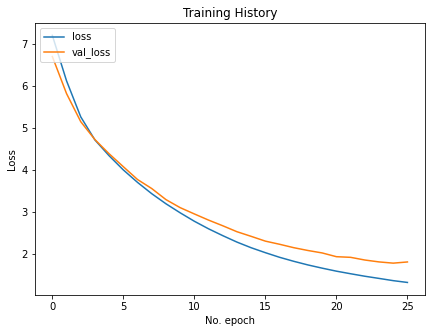

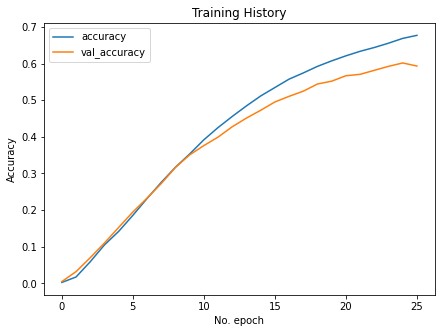

In [18]:
plot_history(history.history, ["loss", "val_loss"], ylabel="Loss")
plot_history(history.history, ["accuracy", "val_accuracy"], ylabel="Accuracy")

**Testing**

In [19]:
model.evaluate(testX, testY)

640/640 [==============================] - 2s 2ms/step - loss: 1.7989 - accuracy: 0.6003


[1.7989404201507568, 0.6003422737121582]

**Prediction**

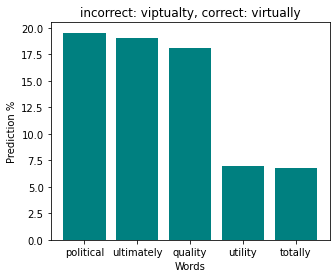

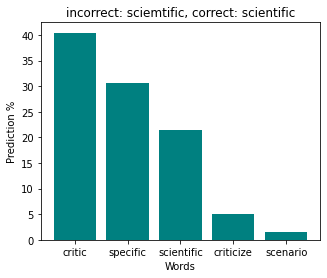

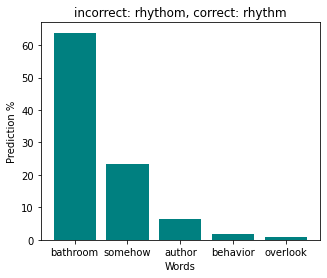

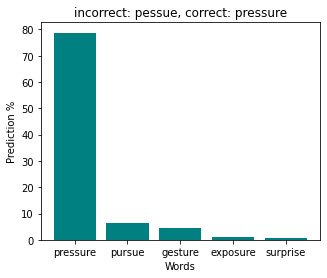

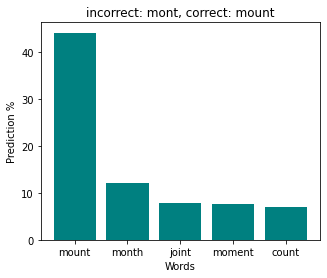

In [22]:
predX = testX[:50:10]
trueX = [decode_string(x) for x in predX]
trueY = label_encoder.inverse_transform(testY[:50:10])
predY = model.predict(predX)

for i in range(predY.shape[0]):
    pred = predY[i]
    pred = list(map(lambda x: round(x * 100, 5), pred))
    pred = list(zip(pred, label_encoder.classes_))
    pred = sorted(pred, key=lambda x: x[0], reverse=True)[:5]
    pred = np.array(pred)
    plot_predictions(pred[:, 1], pred[:, 0], title=f"incorrect: {trueX[i]}, correct: {trueY[i]}")